## Data 100 Final Project

For our Data 100 Final Project, we will be conducting analysis using the Basketball Dataset. Firstly, let's set up the notebook and take a look at the provided data.

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import re
from sklearn import preprocessing 

# ignoring warnings
warnings.filterwarnings('ignore')

/Users/kevin/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)
np.random.seed(100)

In [3]:
# importing data from given csv files
scores = pd.read_csv('2012-18_officialBoxScore.csv')
player_scores = pd.read_csv('2012-18_playerBoxScore.csv')
standings = pd.read_csv('2012-18_standings.csv')
team_scores = pd.read_csv('2012-18_teamBoxScore.csv')
college = pd.read_csv('college.csv')
draft_cap = pd.read_csv('draft_cap.csv')

In [4]:
scores.head()

,gmDate,gmTime,seasTyp,offLNm,offFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptMin,opptDayOff,opptPTS,opptAST,opptTO,opptSTL,opptBLK,opptPF,opptFGA,opptFGM,opptFG%,oppt2PA,oppt2PM,oppt2P%,oppt3PA,oppt3PM,oppt3P%,opptFTA,opptFTM,opptFT%,opptORB,opptDRB,opptTRB,opptPTS1,opptPTS2,opptPTS3,opptPTS4,opptPTS5,opptPTS6,opptPTS7,opptPTS8,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.25,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4,33.3333,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.25,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.35,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5,33.3333,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.00,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Smith,Michael,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.25,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4,33.3333,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.25,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.35,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5,33.3333,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.00,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
2,2012-10-30,19:00,Regular,Workman,Haywoode,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.25,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4,33.3333,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.25,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.35,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5,33.3333,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.00,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
3,2012-10-30,19:00,Regular,Brothers,Tony,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.35,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5,46.1538,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.00,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.25,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4,46.1538,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.25,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
4,2012-10-30,19:00,Regular,Smith,Michael,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.35,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5,46.1538,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.00,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.25,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4,46.1538,53.8462,11.6279,12.3678,11.2434,17.2414,0.9

In [5]:
player_scores.head()

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamDayOff,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,playDispNm,playStat,playMin,playPos,playHeight,playWeight,playBDate,playPTS,playAST,playTO,playSTL,playBLK,playPF,playFGA,playFGM,playFG%,play2PA,play2PM,play2P%,play3PA,play3PM,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,A.J. Price,Starter,29,PG,74,195,1986-10-07,7,6,1,0,0,1,13,2,0.1538,4,0,0.00,9,2,0.2222,1,1,1.0,1,1,2,CLE,East,Central,Home,Win,0
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Trevor Ariza,Starter,25,SG,80,200,1985-06-30,9,4,0,3,2,0,8,3,0.3750,4,1,0.25,4,2,0.5000,2,1,0.5,1,2,3,CLE,East,Central,Home,Win,0
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Emeka Okafor,Starter,25,C,82,255,1982-09-28,10,0,1,0,4,1,10,4,0.4000,10,4,0.40,0,0,0.0000,4,2,0.5,5,2,7,CLE,East,Central,Home,Win,0
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Bradley Beal,Starter,22,SG,77,202,1993-06-28,8,3,2,1,0,1,8,2,0.2500,4,0,0.00,4,2,0.5000,2,2,1.0,0,3,3,CLE,East,Central,Home,Win,0
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Southeast,Away,Loss,0,Brothers,Tony,Smith,Michael,Workman,Haywoode,Trevor Booker,Starter,17,PF,79,240,1987-11-25,4,1,4,1,1,4,9,2,0.2222,8,2,0.25,1,0,0.0000,0,0,0.0,1,0,1,CLE,East,Central,Home,Win,0


In [6]:
standings.head()

,stDate,teamAbbr,rank,rankOrd,gameWon,gameLost,stk,stkType,stkTot,gameBack,ptsFor,ptsAgnst,homeWin,homeLoss,awayWin,awayLoss,confWin,confLoss,lastFive,lastTen,gamePlay,ptsScore,ptsAllow,ptsDiff,opptGmPlay,opptGmWon,opptOpptGmPlay,opptOpptGmWon,sos,rel%Indx,mov,srs,pw%,pyth%13.91,wpyth13.91,lpyth13.91,pyth%16.5,wpyth16.5,lpyth16.5
0,2012-10-30,ATL,3,3rd,0,0,-,-,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
1,2012-10-30,BKN,3,3rd,0,0,-,-,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
2,2012-10-30,BOS,14,14th,0,1,L1,loss,1,1.0,107,120,0,0,0,1,0,1,0,0,1,107.0,120.0,-13.0,0,0,0,0,0.0,0.0,-13.0,-13.0,0.072,0.1687,13.8334,68.1666,0.131,10.742,71.258
3,2012-10-30,CHA,3,3rd,0,0,-,-,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
4,2012-10-30,CHI,3,3rd,0,0,-,-,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000


In [7]:
team_scores.head()

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptMin,opptDayOff,opptPTS,opptAST,opptTO,opptSTL,opptBLK,opptPF,opptFGA,opptFGM,opptFG%,oppt2PA,oppt2PM,oppt2P%,oppt3PA,oppt3PM,oppt3P%,opptFTA,opptFTM,opptFT%,opptORB,opptDRB,opptTRB,opptPTS1,opptPTS2,opptPTS3,opptPTS4,opptPTS5,opptPTS6,opptPTS7,opptPTS8,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.2500,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4000,33.3333,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.25,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.3500,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5000,33.3333,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.000,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.3500,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5000,46.1538,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.00,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.2500,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4000,46.1538,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.250,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,East,Atlantic,Away,Loss,240,0,107,24,16,4,2,23,75,39,0.5200,62,33,0.5323,13,6,0.4615,28,23,0.8214,7,34,41,25,29,22,31,0,0,0,0,53.2468,61.5385,0.6127,0.5600,18.4211,87.1795,15.4859,4.2113,2.1056,3.2258,1.4267,75.25,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,MIA,East,Southeast,Home,Win,240,0,120,25,8,8,5,20,79,43,0.5443,63,35,0.5556,16,8,0.5000,32,26,0.8125,5,31,36,31,31,31,27,0,0,0,0,46.7532,58.1395,0.6446,0.5949,13.8889,86.1111,7.9145,8.4225,5.2641,7.9365,1.5190,97.000,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,East,Southeast,Home,Win,240,0,120,25,8,8,5,20,79,43,0.5443,63,35,0.5556,16,8,0.5000,32,26,0.8125,5,31,36,31,31,31,27,0,0,0,0,46.7532,58.1395,0.6446,0.5949,12.8205,81.5789,7.9145,8.4225,5.2641,7.9365,1.5190,97.00,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,BOS,East,Atlantic,Away,Loss,240,0,107,24,16,4,2,23,75,39,0.5200,62,33,0.5323,13,6,0.4615,28,23,0.8214,7,34,41,25,29,22,31,0,0,0,0,53.2468,61.5385,0.6127,0.5600,17.0732,82.9268,15.4859,4.2113,2.1056,3.2258,1.4267,75.250,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,West,Southwest,Away,Win,240,0,99,22,12,9,5,25,85,40,0.4706,70,35,0.5000,15,5,0.3333,18,14,0.7778,9,31,40,25,23,26,25,0,0,0,0,46.5116,55.0000,0.5327,0.5000,22.5000,67.3913,11.4373,9.8276,5.4598,7.1429,1.1647,72.25,60.2083,108.1034,99.3678,8.7356,0.4545,17.3338,1.8

In [8]:
college.head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,NBA__3ptapg,NBA__3ptpct,NBA__3ptpg,NBA_efgpct,NBA_fg%,NBA_fg_per_game,NBA_fga_per_game,NBA_ft%,NBA_ft_per_g,NBA_fta_p_g,NBA_g_played,NBA_ppg,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240.0,0.0,0.000,0.0,0.502,0.502,2.4,4.8,0.701,0.9,1.3,256,5.7,0.0,NaN,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235.0,NaN,NaN,NaN,NaN,0.428,3.5,8.2,0.728,2.0,2.8,505,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225.0,0.0,0.056,0.0,0.559,0.559,10.2,18.1,0.721,4.3,6.0,1560,24.6,NaN,NaN,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162.0,2.3,0.354,0.8,0.472,0.442,6.0,13.6,0.905,1.8,2.0,586,14.6,7.2,0.372,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223.0,0.3,0.237,0.1,0.422,0.417,3.1,7.3,0.703,1.6,2.2,236,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question: Can we predict whether a team will make the post-season based on recent past performance?

Namely, we recognize that the most exiting moments of an NBA season typically occur in the post-season. Being able to accurately predict if a given team will advance or not has implications on a large variety of stakeholders (i.e. management, sports betters, etc). 

Our main question revolves around that fact. We're interested in knowing if we can predict if a given team will make it to the post-season. We will primarily use the data given to us, but also supplement it with some external research.

### 1. Data Cleaning

We're going to clean the data given to us into a relevant tabular format (i.e. indexed by season and team), making it easier for us to explore the nuances of our given question.

In [9]:
scores_cpy = scores.copy()
# remove all the opponent stats because they are repeated later
scores_cpy = scores_cpy.iloc[:,:61]

#remove unnecessary stats
scores_cpy.drop(columns=['gmTime', 'seasTyp', 'offLNm', 'offFNm', 'teamConf', 'teamDiv', 'teamLoc', 'teamMin', 'teamDayOff'], 
                inplace=True)

# remove duplicate rows
scores_cpy.drop_duplicates(inplace=True)

# adjust the date to be seasons
scores_cpy['gmDate'] = pd.to_datetime(scores_cpy['gmDate'])
season_range = {'2012/13': (scores_cpy['gmDate'] >= '2012-10-30') & (scores_cpy['gmDate'] <='2013-04-17'), \
          '2013/14': (scores_cpy['gmDate'] >= '2013-10-29') & (scores_cpy['gmDate'] <='2014-04-16'), \
          '2014/15': (scores_cpy['gmDate'] >= '2014-10-28') & (scores_cpy['gmDate'] <='2015-04-15'), \
          '2015/16': (scores_cpy['gmDate'] >= '2015-10-27') & (scores_cpy['gmDate'] <='2016-04-13'), \
          '2016/17': (scores_cpy['gmDate'] >= '2016-10-25') & (scores_cpy['gmDate'] <='2017-04-12'), \
          '2017/18': (scores_cpy['gmDate'] >= '2017-10-17') & (scores_cpy['gmDate'] <='2018-04-11')}

seasons_data = []
for key in season_range.keys():
    curr = scores_cpy.loc[season_range[key]]
    curr['season'] = [key]*len(curr)
    curr.drop(columns=['gmDate'], inplace=True)
    seasons_data.append(curr)
all_seasons = pd.concat(seasons_data)

# one-hot-encoding for Win/Loss to be 1/0. Note that we drop one of these columns because they are linearly dependent
win = pd.get_dummies(all_seasons['teamRslt'], prefix='Result', drop_first = True)['Result_Win']
all_seasons['Win'] = win
all_seasons.drop(columns='teamRslt', inplace=True)

# for each season, find the team's average stats 
stats_by_season = all_seasons.groupby(['season', 'teamAbbr']).mean()

stats_by_season

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
season  teamAbbr                                                         
2012/13 ATL        97.951220  24.475610  14.865854  8.097561  4.500000   
        BKN        96.878049  20.341463  14.707317  7.304878  4.768293   
        BOS        96.518519  22.753086  14.580247  8.234568  4.506173   
        CHA        93.426829  19.353659  14.073171  7.195122  5.841463   
        CHI        93.182927  23.000000  14.280488  7.170732  5.085366   
...                      ...        ...        ...       ...       ...   
2017/18 SA        102.731707  22.792683  13.182927  7.670732  5.597561   
        SAC        98.829268  21.573171  13.743902  7.890244  4.121951   
        TOR       111.634146  24.329268  13.390244  7.646341  6.109756   
        UTA       104.146341  22.426829  14.743902  8.646341  5.134146   
        WAS       106.609756  25.182927  14.634146  7.902439  4.243902   

                     teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
season  teamAbbr                                                         
2012/13 ATL       17.963415  81.024390  37.609756  0.465584  57.841463   
        BKN       18.292683  79.804878  35.878049  0.449987  58.341463   
        BOS       21.197531  79.740741  37.049383  0.466365  62.580247   
        CHA       19.048780  81.085366  34.426829  0.425313  64.024390   
        CHI       19.719512  81.682927  35.682927  0.438539  66.256098   
...                     ...        ...        ...       ...        ...   
2017/18 SA        17.170732  85.341463  39.048780  0.457772  61.231707   
        SAC       19.987805  86.109756  38.768293  0.450896  62.121951   
        TOR       21.743902  87.414634  41.256098  0.472657  54.414634   
        UTA       19.609756  82.878049  38.280488  0.462518  53.304878   
        WAS       21.292683  85.536585  39.939024  0.467939  59.036585   

                    team2PM   team2P%    team3PA    team3PM   team3P%  \
season  teamAbbr                                                        
2012/13 ATL       29.000000  0.504110  23.182927   8.609756  0.373288   
        BKN       28.219512  0.484071  21.463415   7.658537  0.356373   
        BOS       30.901235  0.496393  17.160494   6.148148  0.360021   
        CHA       28.707317  0.448746  17.060976   5.719512  0.333800   
        CHI       30.243902  0.458105  15.426829   5.439024  0.350826   
...                     ...       ...        ...        ...       ...   
2017/18 SA        30.560976  0.499205  24.109756   8.487805  0.352216   
        SAC       29.768293  0.480474  23.987805   9.000000  0.376822   
        TOR       29.451220  0.544145  33.000000  11.804878  0.357084   
        UTA       27.463415  0.518249  29.573171  10.817073  0.366495   
        WAS       30.012195  0.509760  26.500000   9.926829  0.372939   

                    teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
season  teamAbbr                                                         
2012/13 ATL       19.743902  14.121951  0.708479   9.243902  31.621951   
        BKN       23.878049  17.463415  0.732144  12.768293  30.000000   
        BOS       20.962963  16.271605  0.776423   8.074074  31.271605   
        CHA       25.121951  18.853659  0.753800  11.182927  29.134146   
        CHI       21.195122  16.378049  0.774287  12.512195  30.658537   
...                     ...        ...       ...        ...        ...   
2017/18 SA        20.914634  16.146341  0.778084  10.329268  33.853659   
        SAC       16.719512  12.292683  0.740568   9.475610  31.414634   
        TOR       21.829268  17.341463  0.787968   9.780488  34.207317   
        UTA       21.536585  16.768293  0.783278   9.012195  34.231707   
        WAS       21.780488  16.804878  0.774693  10.024390  33.048780   

                    teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
season  teamAbbr                                                          
2012/13 ATL       40.865854  23.

In [10]:
# clean the standings table to work out play-off booleans
# first make dates in date format and then separate by seasons
standings['stDate'] = pd.to_datetime(standings['stDate'])
season_range = {'2012/13': (standings['stDate'] >= '2012-10-30') & (standings['stDate'] <='2013-04-17'), \
          '2013/14': (standings['stDate'] >= '2013-10-29') & (standings['stDate'] <='2014-04-16'), \
          '2014/15': (standings['stDate'] >= '2014-10-28') & (standings['stDate'] <='2015-04-15'), \
          '2015/16': (standings['stDate'] >= '2015-10-27') & (standings['stDate'] <='2016-04-13'), \
          '2016/17': (standings['stDate'] >= '2016-10-25') & (standings['stDate'] <='2017-04-12'), \
          '2017/18': (standings['stDate'] >= '2017-10-17') & (standings['stDate'] <='2018-04-11')}

standings_data = []
for key in season_range.keys():
    curr = standings.loc[season_range[key]]
    curr['season'] = [key]*len(curr)
    standings_data.append(curr)
all_standings = pd.concat(standings_data)

# find standings at end of the season
end_dates = ['2013-04-17', '2014-04-16', '2015-04-15', '2016-04-13', '2017-04-12', '2018-04-11']
all_standings = all_standings[all_standings['stDate'].isin(end_dates)]
all_standings.drop(columns='stDate', inplace=True)
rankings = all_standings[['teamAbbr', 'rank', 'season']]
rankings = rankings.groupby(['season', 'teamAbbr']).mean()

rankings.head()

rank
season  teamAbbr      
2012/13 ATL          6
        BKN          4
        BOS          7
        CHA         14
        CHI          5

In [11]:
# join the rankings and stats_by_season so we know the standings of teams at end of each season
all_data = rankings.join(stats_by_season, how='inner')

# add a boolean value of whether they make playoffs
all_data['playoffs'] = (all_data['rank'] <= 8).astype(int)
all_data.drop(columns='rank', inplace=True)

all_data.head()

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
season  teamAbbr                                                        
2012/13 ATL       97.951220  24.475610  14.865854  8.097561  4.500000   
        BKN       96.878049  20.341463  14.707317  7.304878  4.768293   
        BOS       96.518519  22.753086  14.580247  8.234568  4.506173   
        CHA       93.426829  19.353659  14.073171  7.195122  5.841463   
        CHI       93.182927  23.000000  14.280488  7.170732  5.085366   

                     teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
season  teamAbbr                                                         
2012/13 ATL       17.963415  81.024390  37.609756  0.465584  57.841463   
        BKN       18.292683  79.804878  35.878049  0.449987  58.341463   
        BOS       21.197531  79.740741  37.049383  0.466365  62.580247   
        CHA       19.048780  81.085366  34.426829  0.425313  64.024390   
        CHI       19.719512  81.682927  35.682927  0.438539  66.256098   

                    team2PM   team2P%    team3PA   team3PM   team3P%  \
season  teamAbbr                                                       
2012/13 ATL       29.000000  0.504110  23.182927  8.609756  0.373288   
        BKN       28.219512  0.484071  21.463415  7.658537  0.356373   
        BOS       30.901235  0.496393  17.160494  6.148148  0.360021   
        CHA       28.707317  0.448746  17.060976  5.719512  0.333800   
        CHI       30.243902  0.458105  15.426829  5.439024  0.350826   

                    teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
season  teamAbbr                                                         
2012/13 ATL       19.743902  14.121951  0.708479   9.243902  31.621951   
        BKN       23.878049  17.463415  0.732144  12.768293  30.000000   
        BOS       20.962963  16.271605  0.776423   8.074074  31.271605   
        CHA       25.121951  18.853659  0.753800  11.182927  29.134146   
        CHI       21.195122  16.378049  0.774287  12.512195  30.658537   

                    teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
season  teamAbbr                                                          
2012/13 ATL       40.865854  23.841463  24.768293  24.975610  23.402439   
        BKN       42.768293  26.158537  24.109756  22.731707  23.000000   
        BOS       39.345679  24.481481  24.395062  23.333333  22.493827   
        CHA       40.317073  23.195122  23.841463  22.804878  23.000000   
        CHI       43.170732  23.341463  23.621951  22.695122  22.756098   

                  teamPTS5  teamPTS6  teamPTS7  teamPTS8  teamTREB%  \
season  teamAbbr                                                      
2012/13 ATL       0.548780  0.414634  0.000000       0.0  48.451795   
        BKN       0.658537  0.219512  0.000000       0.0  52.145094   
        BOS       1.296296  0.382716  0.135802       0.0  47.419702   
        CHA       0.475610  0.109756  0.000000       0.0  47.837867   
        CHI       0.768293  0.000000  0.000000       0.0  51.261163   

                  teamASST%   teamTS%  teamEFG%  teamOREB%  teamDREB%  \
season  teamAbbr                                                        
2012/13 ATL       64.917021  0.546949  0.519068  22.058495  74.082923   
        BKN       56.829796  0.537116  0.498278  30.775823  73.941318   
        BOS       61.464602  0.543958  0.505091  19.849091  73.645579   
        CHA       55.989220  0.507712  0.460761  25.550113  71.441363   
        CHI       64.236896  0.513213  0.471784  29.168224  73.886277   

                    teamTO%  teamSTL%  teamBLK%  teamBLKR   teamPPS  \
season  teamAbbr                                                      
2012/13 ATL       14.275735  8.632868  4.807234  7.865539  1.213796   
        BKN       14.013863  8.131777  5.334624  8.313509  1.218228   
        BOS       14.087037  8.759989  4.804304  7.320688  1.216717   
        CHA       13.248724  7.782578  6.336188  9.213826  1.156089   
   

In [12]:
# clean draft and salary data
draft_cap.drop(columns=['Unnamed: 0'], inplace=True)
draft_cap.rename(columns={'Team': 'teamAbbr'}, inplace=True)
draft_cap.groupby(['season', 'teamAbbr']).mean()
draft_cap.set_index(['season', 'teamAbbr'], inplace= True)

In [13]:
# add draft pick and salary data to all data
all_data = all_data.join(draft_cap, how='inner')

### 2. Preliminary Exploratory Data Analysis

Though intuitive, we wanted to substantiate our hypothesis from the data (that prior performance is indicative of future performance). Let's visualize how teams' rankings have adjusted over time.

Note, with 30 teams, it would be almost impossible to try to visualize ranking movement over time of the entire NBA. Instead, we have segmented our visualizations into the 6 divisions. Some quick research shows that the composition of these divisions has not changed within the past 8 years; hence, we will run into no issues with contigency. We also assume that cases of rebranding (i.e. the Charlotte Bobcats rebranded into the Hornets), have no serious implications on team performance.

In [14]:
# flatten the multi-indexed rankings dataframe
flattened_rankings = pd.DataFrame(rankings.to_records())

# use regex to convert the String season into a meaningful int
start_years = flattened_rankings['season'].str.extract('(.*)\/')[0]
flattened_rankings['startYear'] = pd.to_numeric(start_years)

# introduce divisions and take relevant columns
merged_rankings = flattened_rankings.merge(scores, on='teamAbbr').groupby(['teamAbbr', 'startYear']).first()
merged_rankings = pd.DataFrame(merged_rankings[['rank', 'teamDiv']].to_records())

merged_rankings.head()

,teamAbbr,startYear,rank,teamDiv
0,ATL,2012,6,Southeast
1,ATL,2013,8,Southeast
2,ATL,2014,1,Southeast
3,ATL,2015,3,Southeast
4,ATL,2016,5,Southeast


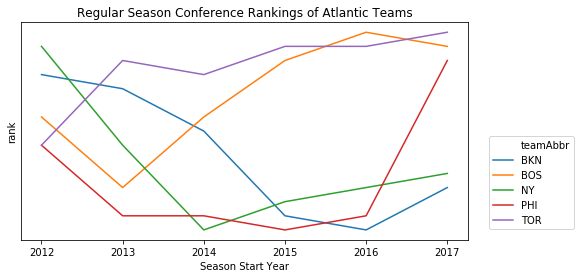

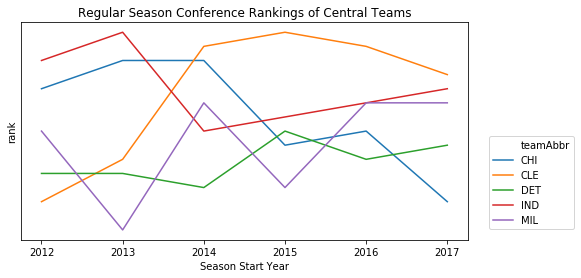

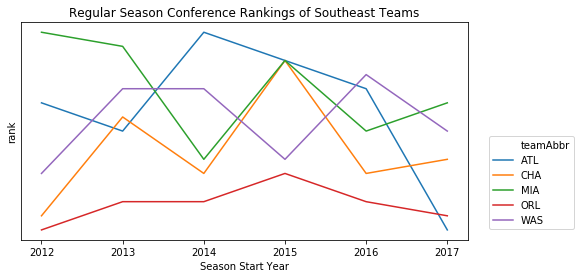

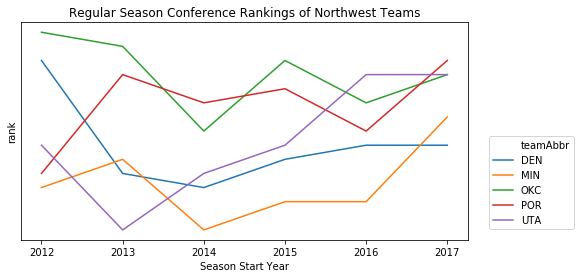

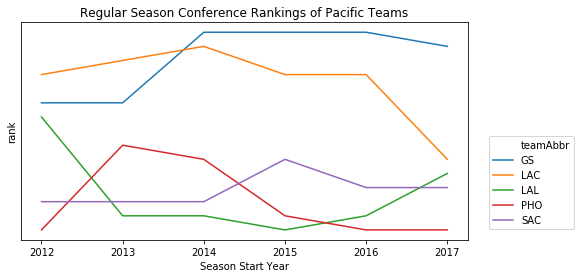

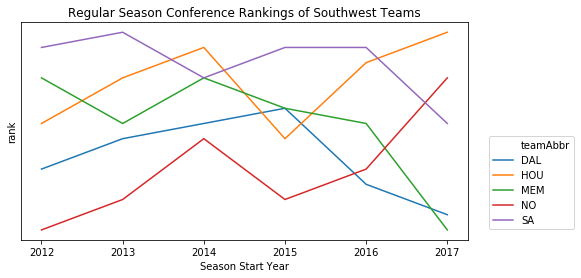

In [15]:
# list of all possible divisions
divisions = ['Atlantic', 'Central', 'Southeast', 'Northwest', 'Pacific', 'Southwest']

# plotting for the separate divisions
for division in divisions:
    plt.figure(figsize=(8, 4))
    atlantic = sns.lineplot('startYear', 'rank', data=merged_rankings[merged_rankings['teamDiv'] == division], 
                            hue='teamAbbr')
    atlantic.legend(loc='bottom right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title('Regular Season Conference Rankings of {} Teams'.format(division))
    plt.xlabel('Season Start Year')
    plt.yticks(range(1))
    
    # inverting y axis because lower ranks are better, makes the visualization more intuitive
    plt.gca().invert_yaxis()
    plt.show();

These visualizations show us that most teams tend to either fluctuate around the same standings or progressively trend towards either towards the top or the bottom of the standings. Teams that 'spike' between positions (like Charlotte in Southeast division) are pretty uncommon, or that quickly rise up the standings (like Philadelphia in the Atlantic division from the 16/17 to 17/18 season). Hence, our hypothesis is pretty valid. We account for fluctuations through a moving average of statistics over the past 3 seasons.

After some external research, we discovered that sudden team improvements (like the 76ers as mentioned above) are largely due to obtaining leverage after obtaining high draft picks in the NBA lottery (either through getting a new young talent to build a team around, or trading for better components). Hence, this should be a major factor that we consider.

<b> TODO: Add part about why (do some research into maybe why Hornets had such a good season in 15/16) </b>

### 3. Feature Engineering/More EDA

Now, we want to discover which features are most correlated to success, potentially identify redudancy/multicollinearity, and identify significant features that our data doesn't fully address.

In [16]:
# create a new table which has the mean of past 3 seasons and whether the team makes playoffs next season. 
# Note the input into 'rolling' is the # seasons for our moving average window
mov_avg_data = all_data.groupby('teamAbbr').rolling(3).mean()

# remove the NaN rows which exist because first 2 seasons for MA don't exist 
mov_avg_data = mov_avg_data.dropna()
mov_avg_data.index = mov_avg_data.index.droplevel(2)

mov_avg_data.head()

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
teamAbbr season                                                          
ATL      2013/14   99.983740  24.752033  15.126016  8.227642  4.150407   
         2014/15  101.516260  25.174797  14.918699  8.552846  4.191057   
         2015/16  102.130081  25.414634  14.821138  8.833333  4.849593   
         2016/17  102.849593  24.995935  14.995935  8.792683  5.150407   
         2017/18  103.117886  24.329268  15.434959  8.361789  5.024390   

                     teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
teamAbbr season                                                          
ATL      2013/14  18.808943  81.382114  37.422764  0.460866  56.451220   
         2014/15  18.743902  81.605691  37.573171  0.461410  55.654472   
         2015/16  18.715447  82.560976  38.008130  0.461434  55.752033   
         2016/17  18.365854  83.500000  38.260163  0.459267  56.605691   
         2017/18  18.971545  84.784553  38.296748  0.452790  56.296748   

                    team2PM   team2P%    team3PA    team3PM   team3P%  \
teamAbbr season                                                         
ATL      2013/14  28.308943  0.503432  24.930894   9.113821  0.364272   
         2014/15  28.004065  0.504750  25.951220   9.569106  0.366572   
         2015/16  28.247967  0.508332  26.808943   9.760163  0.363832   
         2016/17  28.658537  0.508111  26.894309   9.601626  0.357689   
         2017/18  28.292683  0.505010  28.487805  10.004065  0.352122   

                    teamFTA    teamFTM   teamFT%   teamORB    teamDRB  \
teamAbbr season                                                         
ATL      2013/14  21.069106  16.024390  0.758148  8.878049  31.394309   
         2014/15  21.540650  16.800813  0.780812  8.703252  31.471545   
         2015/16  20.955285  16.353659  0.779136  8.560976  32.313008   
         2016/17  22.000000  16.727642  0.760153  9.097561  33.252033   
         2017/18  21.670732  16.520325  0.763680  9.203252  33.581301   

                    teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
teamAbbr season                                                           
ATL      2013/14  40.272358  24.182927  25.150407  25.203252  24.443089   
         2014/15  40.174797  24.662602  25.426829  25.447154  25.207317   
         2015/16  40.873984  24.825203  25.247967  25.808943  25.613821   
         2016/17  42.349593  25.166667  25.260163  26.032520  25.707317   
         2017/18  42.784553  25.186992  24.865854  26.142276  26.288618   

                  teamPTS5  teamPTS6  teamPTS7  teamPTS8  teamTREB%  \
teamAbbr season                                                       
ATL      2013/14  0.711382  0.292683  0.000000   0.00000  48.074269   
         2014/15  0.581301  0.191057  0.000000   0.00000  47.999857   
         2015/16  0.504065  0.130081  0.000000   0.00000  47.868110   
         2016/17  0.512195  0.093496  0.028455   0.04878  48.696192   
         2017/18  0.500000  0.056911  0.028455   0.04878  48.815200   

                  teamASST%   teamTS%  teamEFG%  teamOREB%  teamDREB%  \
teamAbbr season                                                         
ATL      2013/14  66.117376  0.552580  0.517171  21.201180  74.428324   
         2014/15  67.010231  0.558573  0.520333  20.927630  74.250003   
         2015/16  66.774324  0.557661  0.520825  20.238078  74.333095   
         2016/17  65.175983  0.553348  0.517164  21.160445  74.931963   
         2017/18  63.409703  0.548108  0.512171  21.018090  75.862508   

                    teamTO%  teamSTL%  teamBLK%  teamBLKR   teamPPS  \
teamAbbr season                                                       
ATL      2013/14  14.334213  8.646084  4.392099  7.396321  1.233408   
         2014/15  14.078541  8.977719  4.426959  7.578042  1.249134   
         2015/16  13.901768  9.196565  5.065612  8.791237  1.242398   
         2016/17  13.856358  9.080198  5.323939  9.252174  1.237152 

In [17]:
# add a column of whether the team made playoffs in the next season
# 2018-19 season playoffs data which is manually inputted from wikipedia
season_1819 = pd.DataFrame()
season_1819['teamAbbr'] = rankings.index.get_level_values('teamAbbr').unique().tolist()
season_1819['playoffs'] = [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
season_1819['season'] = ['201819'] * len(season_1819)
seasons_playoff = all_data['playoffs'].reset_index()
seasons_playoff.append(season_1819)

# remove the 2012-13 season data
seasons_playoff = seasons_playoff[seasons_playoff['season'] != '201213']
seasons_playoff.columns = ['next_season', 'teamAbbr', 'next_playoffs']

In [18]:
# using a dictionary of dates, have a column of the next season
dates_dict = {'2012/13': '2013/14', \
             '2013/14': '2014/15', \
             '2014/15': '2015/16', \
             '2015/16': '2016/17', \
             '2016/17': '2017/18', \
             '2017/18': '2018/19'}
mov_avg_data_new = mov_avg_data.reset_index().copy()
mov_avg_data_new['next_season'] = mov_avg_data_new['season'].map(dates_dict)
mov_avg_data_new= mov_avg_data_new.merge(seasons_playoff, how='inner', on=['teamAbbr', 'next_season'])

mov_avg_data_new.head()

,teamAbbr,season,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,Win,playoffs,salarycap,Pick,next_season,next_playoffs
0,ATL,2013/14,99.983740,24.752033,15.126016,8.227642,4.150407,18.808943,81.382114,37.422764,0.460866,56.451220,28.308943,0.503432,24.930894,9.113821,0.364272,21.069106,16.024390,0.758148,8.878049,31.394309,40.272358,24.182927,25.150407,25.203252,24.443089,0.711382,0.292683,0.000000,0.00000,48.074269,66.117376,0.552580,0.517171,21.201180,74.428324,14.334213,8.646084,4.392099,7.396321,1.233408,76.069614,62.858557,105.532644,105.779457,-0.246812,0.427126,18.870494,1.756186,57.416532,0.487805,1.000000,6.796646e+07,19.333333,2014/15,1
1,ATL,2014/15,101.516260,25.174797,14.918699,8.552846,4.191057,18.743902,81.605691,37.573171,0.461410,55.654472,28.004065,0.504750,25.951220,9.569106,0.366572,21.540650,16.800813,0.780812,8.703252,31.471545,40.174797,24.662602,25.426829,25.447154,25.207317,0.581301,0.191057,0.000000,0.00000,47.999857,67.010231,0.558573,0.520333,20.927630,74.250003,14.078541,8.977719,4.426959,7.578042,1.249134,78.169207,64.766062,106.977331,105.362488,1.614843,0.428007,19.108111,1.807807,60.634361,0.552846,1.000000,6.403778e+07,16.666667,2015/16,1
2,ATL,2015/16,102.130081,25.414634,14.821138,8.833333,4.849593,18.715447,82.560976,38.008130,0.461434,55.752033,28.247967,0.508332,26.808943,9.760163,0.363832,20.955285,16.353659,0.779136,8.560976,32.313008,40.873984,24.825203,25.247967,25.808943,25.613821,0.504065,0.130081,0.000000,0.00000,47.868110,66.774324,0.557661,0.520825,20.238078,74.333095,13.901768,9.196565,5.065612,8.791237,1.242398,80.065549,66.363096,106.721125,103.683096,3.038029,0.428327,19.173161,1.838486,63.002015,0.593496,1.000000,6.810432e+07,16.000000,2016/17,1
3,ATL,2016/17,102.849593,24.995935,14.995935,8.792683,5.150407,18.365854,83.500000,38.260163,0.459267,56.605691,28.658537,0.508111,26.894309,9.601626,0.357689,22.000000,16.727642,0.760153,9.097561,33.252033,42.349593,25.166667,25.260163,26.032520,25.707317,0.512195,0.093496,0.028455,0.04878,48.696192,65.175983,0.553348,0.517164,21.160445,74.931963,13.856358,9.080198,5.323939,9.252174,1.237152,80.771341,66.895622,106.392763,103.494349,2.898414,0.428418,18.703422,1.796088,62.217076,0.613821,1.000000,8.065118e+07,17.000000,2017/18,0
4,BOS,2013/14,96.426980,22.184984,14.846181,7.863696,4.398424,21.217053,81.140169,36.878450,0.456558,62.671384,30.442286,0.488546,18.468785,6.436164,0.349072,20.910268,16.233915,0.779413,9.366456,31.030663,40.397119,24.406354,24.669879,23.169377,22.882064,0.953628,0.255144,0.090535,0.00000,48.323976,60.128253,0.535622,0.496414,22.257498,73.926809,14.134951,8.366882,4.685393,7.118139,1.195471,69.362353,56.975149,103.123049,104.928396,-1.805347,0.426457,17.336465,1.586338,55.804648,0.439075,0.666667,8.210759e+07,19.666667,2014/15,1


Now, let's see which of our current features is most correlated with playoff qualification.

In [19]:
# finding the top 10 features in correlation magnitude with next year playoff qualification
# We start the index at 1 to remove the perfect correlation between next_playoff and itself
mov_avg_data_new.corr()['next_playoffs'].abs().sort_values(ascending=False)[1:11]

playoffs      0.680474
teamEDiff     0.527720
Win           0.515920
teamDrtg      0.507753
teamAST/TO    0.454771
teamFT%       0.453329
teamAR        0.440633
teamSTL/TO    0.399178
teamPTS5      0.371481
Pick          0.366217
Name: next_playoffs, dtype: float64

To gain a better understanding of the nuances of our question (and for curiosity's sake), let's also take a look at the worst features.

In [20]:
# finding the worst 10 features in correlation magnitude with next year playoff qualification
mov_avg_data_new.corr()['next_playoffs'].abs().sort_values()[:10]

teamFTM      0.003298
teamPTS2     0.010615
teamDREB%    0.043399
teamBLK      0.047023
team2PM      0.047249
teamTREB%    0.056050
teamBLK%     0.072595
teamPTS1     0.074625
team3PA      0.081781
teamPF       0.081928
Name: next_playoffs, dtype: float64

Some of these findings are largely intuitive. For example, we would expect that teams with more wins will naturally do better, and given our findings in previous sections, that teams who have been making the playoffs in recent years to do so again. On the other hand, since free throws have inherently lower point values, they matter less when compared to field goals. "Period 7" (or the third period of overtime) is also extremeley rare. Hence, performance in that period also isn't a good indication.

Some, however, are not. These include turnovers not contributing that much (though they seem to be a pinacle point of statistical analysis by many basketball pundits). 

Nevertheless, we notice that a large majority of high correlation magnitudes are based on shooting efficiency. We hypothesize that there's probably much redundancy in these features.

<b> TODO: make a function to create this heatmap instead of repeating code </b>

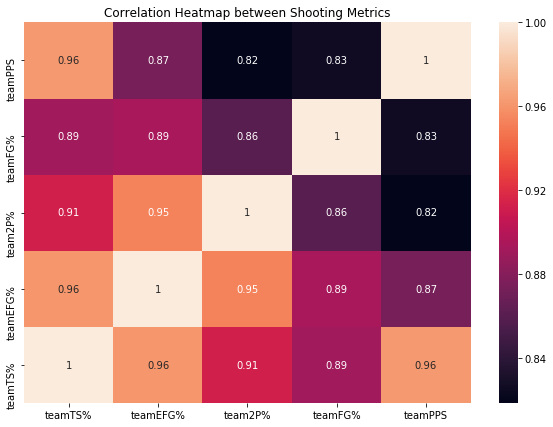

In [21]:
shooting_metrics = mov_avg_data_new[['teamTS%', 'teamEFG%', 'team2P%', 'teamFG%', 'teamPPS']]

plt.figure(figsize=(10, 7))
shot_heatmap = sns.heatmap(shooting_metrics.corr(), annot=True)
plt.title("Correlation Heatmap between Shooting Metrics")

# this line of code below fixes a sns.heatmap bug with newer iterations of matplotlib
shot_heatmap.set_ylim(0, 5);

Unsurprisingly, these features are highly correlated. We should probably only use one. We choose True Shooting Percentage because it's both the highest correlated and the best comprehensive metric for all shooting efficiency.

We now go through all the possible features again, repeat this process, and pick out a set of features that are both indicative, and uncorrelated with each other. An interesting observation from the heatmap below is that defensive rating seems to be negatively correlated with playoff contention. This seems counter-intuitive; after all, "defense wins championships." It's worth noting that lower defensive ratings are actually better (i.e. lower scores mean better defenses) given the NBA's definition. Hence, it's not really that counterintuitive.

<b> TODO: fix redundacy still </b>

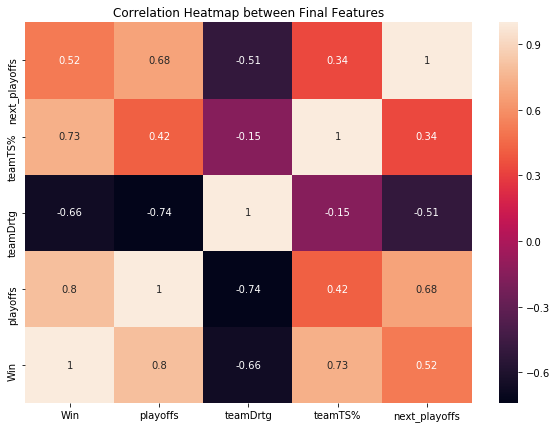

In [22]:
final_features = ['Win', 'playoffs', 'teamDrtg', 'teamTS%']

final_mov_avg = mov_avg_data_new[final_features + ['next_playoffs']]
plt.figure(figsize=(10, 7))
shot_heatmap = sns.heatmap(final_mov_avg.corr(), annot=True)
plt.title("Correlation Heatmap between Final Features")

# this line of code below fixes a sns.heatmap bug with newer iterations of matplotlib
shot_heatmap.set_ylim(0, 5);

### 4. Initial Model Selection

Let's try to fit a diverse range of models to see how well we can predict NBA playoff qualification with only our given dataset

In [23]:
# Now we have all our training data and labels
training_data = mov_avg_data_new.drop(columns = ['teamAbbr', 'season', 'next_season'])

# shuffle all the training data so that time (i.e. same season) isn't a bias in CV
# training_data = training_data.sample(frac=1, random_state=100).reset_index(drop=True)

X = training_data.drop(columns = 'next_playoffs')
y = training_data['next_playoffs']

# split off a portion of the data to use as test data. Shuffling is automatically done.
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

# normalize the data 
mm_scaler = preprocessing.MinMaxScaler()
train_x = pd.DataFrame(mm_scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(mm_scaler.transform(test_x), columns=test_x.columns)

#### Model 4.1: Naive Baseline Predictor

We'll create a baseline predictor that simply predicts playoff qualification based on past season's performance (i.e. teams who made the playoffs in the past will make it again).

In [24]:
# using a dictionary of dates, have a column of the next season
dates_dict = {'2012/13': '2013/14', \
             '2013/14': '2014/15', \
             '2014/15': '2015/16', \
             '2015/16': '2016/17', \
             '2016/17': '2017/18', \
             '2017/18': '2018/19'}
baseline_df = all_data.reset_index().copy()
baseline_df['next_season'] = mov_avg_data_new['season'].map(dates_dict)
baseline_df = baseline_df.merge(seasons_playoff, how='inner', on=['teamAbbr', 'next_season'])

baseline_x = baseline_df.drop(['next_playoffs', 'season', 'teamAbbr', 'next_season'], axis=1)
baseline_y = baseline_df['next_playoffs']
base_train_x, base_test_x, base_train_y, base_test_y = train_test_split(baseline_x, baseline_y, test_size=0.1, random_state=42)

# normalize the data using minmaxscaler
mm_scaler = preprocessing.MinMaxScaler()
base_train_x = pd.DataFrame(mm_scaler.fit_transform(base_train_x), columns=base_train_x.columns)
base_test_x = pd.DataFrame(mm_scaler.transform(base_test_x), columns=base_test_x.columns)


In [25]:
class naive_predictor:
    def init(self):
        pass
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self):
        return self.X['playoffs'] == 1.0
    
    def score(self):
        return np.average((self.X['playoffs'] == 1.0) == self.y)

    
baseline = naive_predictor()
baseline.fit(base_train_x, base_train_y.astype(float).reset_index()['next_playoffs'])
baseline.score()

0.7604166666666666

Roughly 76% accuracy is decent for a baseline/naive predictor. It does beat guessing at random (which would converge to a 50% accuracy). Let's see if we can make our predictor more sophisticated in future iterations.

#### Model 4.2a: Majority Predictor

Let's enhance our naive predictor to account for our feature engineering. Namely, we'll predict that a team makes the playoffs if the team made more than 50% of the playoffs in the past 3 seasons (since there are exactly 3 seasons, it's impossible to qualify exactly 50% of the time).

In [26]:
class mav_predictor:
    def init(self):
        pass
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self):
        return self.X['playoffs'] > 0.5
    
    def score(self):
        return np.average((self.X['playoffs'] > 0.5) == self.y)
    
    def wrong_predictions(self):
        return self.X[self.predict() != self.y]
    
mav = mav_predictor()
mav.fit(train_x, train_y.astype(float).reset_index()['next_playoffs'])
mav.score()

0.8313253012048193

Using the moving average helps us make much better predictions, even without a sophisticated mechanism. This reinforces our idea that we can somewhat guess playoff qualification well using recent past performance. 

#### Model 4.3a: Logistic Regression with Feature Selection

We'll now perform logistic regression on our selected features.

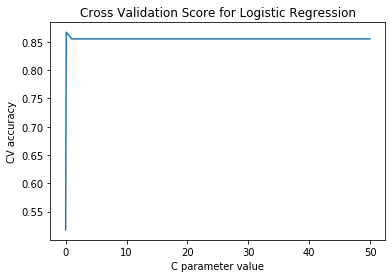

In [27]:
train_x_cleaned = train_x[final_features]
Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]

logreg_score = []
for C in Cs:
    logreg_naive = LogisticRegression(C=C, random_state=42)
    logreg_score.append(np.mean(cross_val_score(logreg_naive, train_x_cleaned, train_y, cv=5)))

plt.plot(Cs, logreg_score)
plt.title('Cross Validation Score for Logistic Regression')
plt.xlabel('C parameter value')
plt.ylabel('CV accuracy');

In [28]:
logreg_naive = LogisticRegression(C=50, random_state=42)
logreg_naive.fit(train_x_cleaned, train_y)
logreg_preds = logreg_naive.predict(test_x[final_features])
logreg_accuracy = accuracy_score(test_y, logreg_preds)
print('The test accuracy of logistic regression is: ', logreg_accuracy)

The test accuracy of logistic regression is:  0.9


#### Model 4.3b: Decision Tree Classifier with Feature Selection

In [29]:
decisiontree_naive = DecisionTreeClassifier(random_state=42)
decisiontree_score = np.mean(cross_val_score(decisiontree_naive, train_x_cleaned, train_y, cv=5))
print('The cross validation accuracy of decision tree is: ', decisiontree_score)

decisiontree_naive.fit(train_x_cleaned, train_y)
decisiontree_preds = decisiontree_naive.predict(test_x[final_features])
decisiontree_accuracy = accuracy_score(test_y, decisiontree_preds)
print('The test accuracy of decision tree is: ', decisiontree_accuracy)

The cross validation accuracy of decision tree is:  0.8088235294117647
The test accuracy of decision tree is:  0.8


Note, the lower CV score is expected due to the nature of decision trees to overfit.

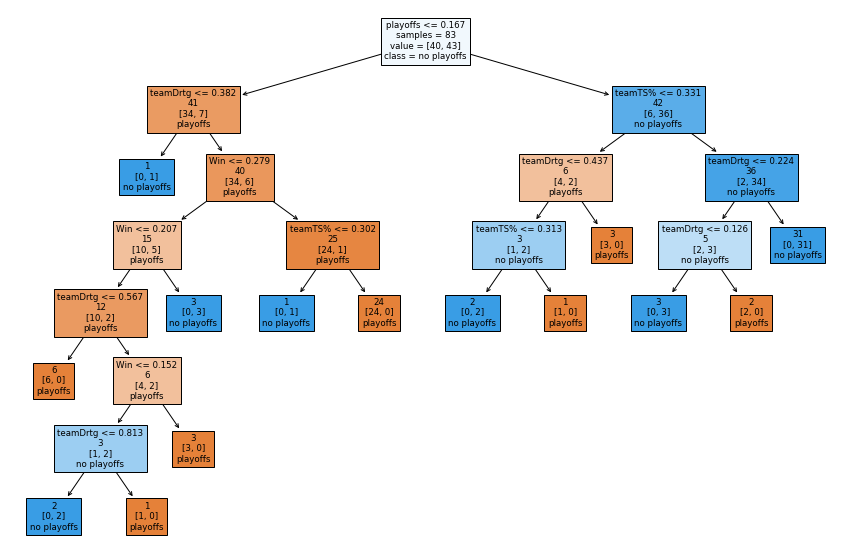

In [30]:
decisiontree_naive.fit(train_x_cleaned, train_y)
plt.figure(figsize=(15,10))
plot_tree(decisiontree_naive, feature_names = train_x_cleaned.columns, \
          filled=True, label='root', \
          impurity=False, \
         class_names = ['playoffs', 'no playoffs']);

#### Model 4.3c: Random Forest Classifier with Feature Selection

In [31]:
depths = [1, 5, 10, 15, 20]
num_trees = [1, 5, 10, 100, 1000]
max_features = ['auto', 'log2', None]
randomforest_scores = []
best_depth = -100
best_num_trees = -100
best_split = -100
max_score = -10000
for depth in depths:
    for n in num_trees:
        for m in max_features:
            randomforest = RandomForestClassifier(max_depth = depth, n_estimators=n, random_state=42, \
                                                  max_features=m)
            curr = np.mean(cross_val_score(randomforest, train_x, train_y, cv=5))
            if curr >= max_score:
                best_depth = depth
                best_num_trees = n
                max_score = curr
                best_split= m
print('The best cross validation score for random forest is: ', max_score)
print('The best depth to use is: ', best_depth)
print('The best number of trees to use is: ', best_num_trees)
print('The best number of splits to use is: ', best_split)

The best cross validation score for random forest is:  0.9029411764705882
The best depth to use is:  5
The best number of trees to use is:  5
The best number of splits to use is:  log2


In [32]:
randomforest = RandomForestClassifier(max_depth = 5, n_estimators=5, random_state=42, \
                                     max_features='log2')
randomforest.fit(train_x, train_y)
randomforest_preds = randomforest.predict(test_x)
randomforest_accuracy = accuracy_score(test_y, randomforest_preds)
print('The test accuracy of random forest is: ', randomforest_accuracy)

The test accuracy of random forest is:  0.9


#### Model 4.4: KNN

Let's go above and beyond and incorporate a (largely underrated) classification scheme.

<b> TODO: Kevin maybe add a link to the 189 lecture where the prof talks about how it's underrated </b>

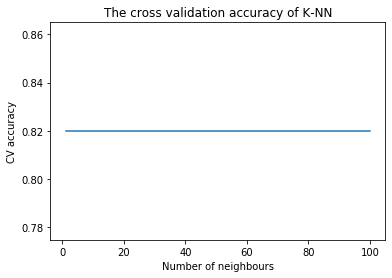

In [33]:
num_neighbours = [1, 5, 10, 20, 50, 100]
neigh_score= []
for n in num_neighbours:
    neigh = KNeighborsClassifier()
    neigh_score.append(np.mean(cross_val_score(neigh, train_x_cleaned, train_y, cv=5)))
plt.plot(num_neighbours, neigh_score)
plt.title('The cross validation accuracy of K-NN')
plt.xlabel('Number of neighbours')
plt.ylabel('CV accuracy');

In [34]:
neigh = KNeighborsClassifier(n_neighbors= 50)
neigh.fit(train_x_cleaned, train_y)
neigh_preds = neigh.predict(test_x[final_features])
neigh_accuracy = accuracy_score(test_y, neigh_preds)
print('The test accuracy of K-NN is: ', neigh_accuracy)

The test accuracy of K-NN is:  0.8


### 5. Additional Feature Engineering

To find ways to improve our models, we should probably take a look at the teams where our slightly mare sophisticated maj classifier didn't guess right.

In [35]:
wrong_X = mav.wrong_predictions()

# reintroduce the names and seasons for these teams
team_info = mov_avg_data_new[mov_avg_data_new.index.isin(wrong_X.index)]
wrong_X = pd.DataFrame(StandardScaler().fit_transform(wrong_X), columns=wrong_X.columns, index=wrong_X.index)

wrong_X.head()

,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,Win,playoffs,salarycap,Pick
2,-1.246624,-1.466517,0.133031,-0.172239,1.000142,-0.425095,-1.686941,-1.366376,0.408860,-0.685069,-0.647589,0.407951,-0.135822,-0.182867,-0.062174,0.368480,-0.270224,-1.102866,0.594256,0.075484,0.675490,-1.579927,-1.700579,0.963943,-0.394430,-1.083710,-0.957790,-0.589890,-0.27735,1.493431,-1.258211,0.254439,0.343851,1.009893,1.165255,0.741086,0.285770,1.276757,1.022625,0.480796,-0.478859,-0.420378,0.356125,-0.744197,0.695013,0.425359,-1.302514,-1.605371,-0.839439,0.332934,-0.83666,-1.152725,0.087731
9,1.612355,1.234201,1.731235,1.036457,0.092494,1.582671,1.228162,1.103959,-0.174957,-1.122970,-0.857483,1.120950,1.739863,1.633706,-1.016160,-0.899737,-0.288660,0.646142,-1.268402,0.882067,-0.250148,0.910682,2.114871,0.736039,0.426410,-0.633583,-0.328484,-0.589890,-0.27735,-0.943174,1.104931,0.700899,0.776119,-1.387942,0.148179,1.433306,0.557162,-0.311731,0.499667,0.319730,0.597062,0.615407,-0.666129,0.954531,-1.007971,-1.273484,0.902810,-0.380182,-0.724002,-0.717449,-0.83666,2.072271,0.838317
31,-1.293433,0.393511,-0.702297,-1.278196,0.510012,-0.943229,-0.646583,-1.303034,-0.730047,0.807267,0.308594,-1.238817,-1.134603,-1.171159,0.178531,0.251413,0.699526,1.315691,0.886775,0.411560,1.349457,-1.030052,-0.620098,-1.141461,-1.283108,0.452019,0.494455,1.583389,-0.27735,0.778028,1.047330,-0.817814,-1.222681,0.959744,-0.355260,-0.546873,-1.227541,0.728538,0.007023,-0.585193,0.124742,0.069523,-0.041996,-1.494250,0.974120,0.058644,0.802468,1.350288,-0.773087,1.219194,1.67332,0.521873,1.793607
33,0.469123,-0.229126,-0.872772,-0.885370,-1.722802,-0.536638,0.568218,0.602096,0.002730,0.391822,0.296933,-0.289352,-0.117230,0.068127,1.016166,0.028988,-0.030552,-0.223374,0.749119,-0.032807,0.705349,1.649239,0.115230,-0.392632,-0.726836,2.199573,1.220577,-0.589890,-0.27735,0.464365,-0.529915,-0.076820,-0.010417,0.621428,0.336881,-1.105108,-1.057326,-1.645270,-1.400537,-0.144930,-0.021581,-0.072830,0.842702,0.278287,0.283276,0.699371,-0.338668,0.371137,-0.273019,0.431407,0.00000,0.474344,-1.208735
36,-0.510275,-0.544385,-0.966533,-0.625500,-1.759108,0.280141,0.906597,0.134341,-0.900530,1.243127,0.830414,-1.334162,-0.812349,-0.807217,0.273073,-0.392450,-0.299722,-0.054320,1.144880,-0.981289,0.014320,0.215252,-0.177400,-1.380218,-0.679349,1.166927,1.898291,-0.589890,-0.27735,0.078859,-0.725766,-1.336376,-1.238359,0.831316,-0.182765,-1.292472,-0.677566,-1.670386,-1.736308,-1.387206,-1.195104,-1.233751,-0.186661,0.675745,-0.554994,0.226111,-0.768795,0.245009,0.378218,-0.520502,-0.83666,-0.791566,0.360671


In [36]:
wrong_y = train_y[train_y.index.isin(wrong_X.index)]

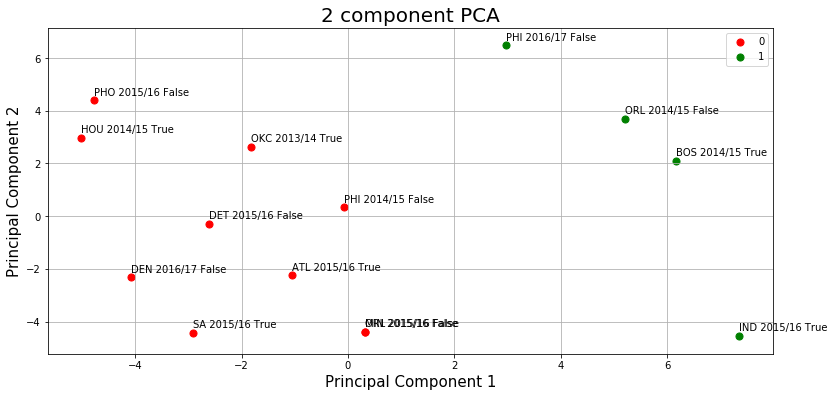

In [37]:
clustering = AgglomerativeClustering(n_clusters=2).fit(wrong_X)
clustering_pca = PCA(2)
principal_df = pd.DataFrame(data = clustering_pca.fit_transform(wrong_X), columns = ['PC 1', 'PC 2'], index=wrong_X.index)
principal_df['cluster'] = clustering.labels_
principal_df['team'] = team_info['teamAbbr']

# the team label includes team name, season, and if they were predicted to make the playoffs next season
playoff_guess = (team_info['playoffs'] > 0.5).astype(str)
principal_df['team'] = principal_df.team.map(str) + " " + team_info['season'] + " " + playoff_guess

# inspiration source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (13,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = principal_df['cluster'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'PC 1']
               ,principal_df.loc[indicesToKeep, 'PC 2']
               ,c = color
               ,s = 50)
    
indices = principal_df.index.to_list()
for i, label in enumerate(principal_df['team']):
    x = principal_df.loc[indices[i], 'PC 1']
    y = principal_df.loc[indices[i], 'PC 2']
    ax.annotate(label, (x, y+0.2)) 

ax.legend(targets)
ax.grid()

We did some external research to see what could have caused these incorrect projections for these teams.

<b> RU TODO: finish this analysis </b>

We found that for group 1, the highest draft pick each of these teams got were:
1. CHI 2016/17: R1, pick 16
2. NO 2016/17: R2, pick 40
3. DAL 2016/17: R1, pick 9
4. DAL 2015/16: R2, pick 46
5. ATL 2016/17: R1, pick 19
6. LAC 2016/17: Did not Select

For group 2, the highest draft pick each of these teams got were:

#### 5.1 Re-doing Logistic Regression with draft pick and salary cap

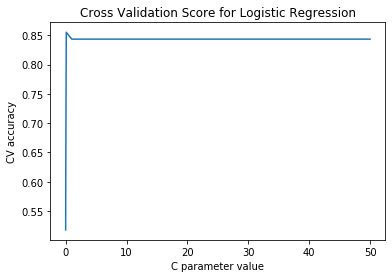

In [38]:
train_x_cleaned = train_x[final_features + ['Pick', 'salarycap']]
Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]

logreg_score = []
for C in Cs:
    logreg_draft_cap= LogisticRegression(C=C)
    logreg_score.append(np.mean(cross_val_score(logreg_draft_cap, train_x_cleaned, train_y, cv=5)))

plt.plot(Cs, logreg_score)
plt.title('Cross Validation Score for Logistic Regression')
plt.xlabel('C parameter value')
plt.ylabel('CV accuracy');

In [39]:
logreg_draft_cap = LogisticRegression(C=50)
logreg_draft_cap.fit(train_x_cleaned, train_y)
logreg_draft_cap_preds = logreg_draft_cap.predict(test_x[final_features + ['Pick', 'salarycap']])
logreg_draft_cap_accuracy = accuracy_score(test_y, logreg_draft_cap_preds)
print('The test accuracy for Logistic Regression with the additional features is: ', logreg_draft_cap_accuracy)

The test accuracy for Logistic Regression with the additional features is:  0.8


### 99. Misc Stuff for now

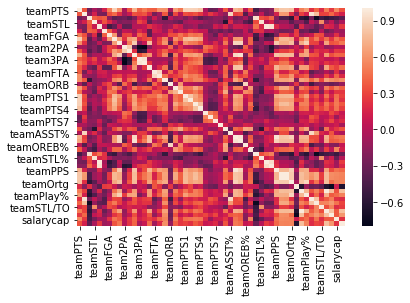

In [40]:
sns.heatmap(train_x.corr())

#### 5. Using PCA + logistic regression
This uses the original train_x (of all features) and tries to find the best features on its own via PCA.

PCA + logistic regression cross validation accuracy:  0.8669117647058823


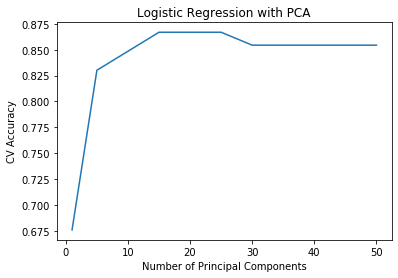

In [41]:
pcas = [1, 5, 15, 20, 25, 30, 50, 100]
pca_lr_score = []
for val in pcas:
    pca = PCA(val)
    logistic = LogisticRegression(max_iter=10000, tol=0.5)
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    pca_lr_score.append(np.mean(cross_val_score(pipe, train_x, train_y, cv=5)))
    
plt.plot(pcas, pca_lr_score)
plt.title('Logistic Regression with PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('CV Accuracy')
print('PCA + logistic regression cross validation accuracy: ', max(pca_lr_score))

In [42]:
pca_best = PCA(20)
logistic_pca = LogisticRegression(max_iter=10000, tol=0.5)
pipe = Pipeline(steps=[('pca', pca_best), ('logistic', logistic_pca)])
pipe.fit(train_x, train_y)
pipe_preds = pipe.predict(test_x)
pipe_accuracy = accuracy_score(test_y, pipe_preds)
print('The test accuracy of PCA with Logistic Regression is: ', pipe_accuracy)

The test accuracy of PCA with Logistic Regression is:  0.9


### Reference Stuff
Data Science Lifecycle:

Either
1. Ask a Question
2. Obtain Data
3. Understand the Data
4. Understand the World/repeat

Or (probably more relevant to our case)
1. Obtain Data
2. Understand the Data
3. Ask a Question
4. Obtain more Data
5. Understand combined data
6. Understand the world/repeat

### Priorities:
1. Build actual naive one (Ru)
    - past 1 season to predict next season playoff. 
2. Find better features (Kevin) 
    - eg. draft picks, budget, conference, division
3. More visualisations (split)
    - cluster teams -> PCA on moving_avg df and then k-means clustering
    - bar chart -> all the models, before/after adding the 'better features' above
    - boxplot -> maybe for budget over 5 years, w/ NBA teams as categorical. Find correlation between the boxplot and their performance 
4. Add k-nn model (Ru)
5. Rename some things eg. mov_avg_model_new and mov_avg_model_new_features

### Questions
– (i) What were two or three of the most interesting features you came across for your particular
question? <br>

– (ii) Describe one feature you thought would be useful, but turned out to be ineffective. <br>
    - a lot of the features were correlated. eg. having true shooting %, we don't need other shooting related.
    - 3pt efficiency was not that indicative of playoffs. Maybe it's because in older seasons, it was not as highly valued as it is nowadays. (include visualisation of how avg 3pt% changed over time) 
    
– (iii) What challenges did you find with your data? Where did you get stuck? <br>
    - multicollinearity, had to find our own data (eg. draft/budget) to improve model 
    
– (iv) What are some limitations of the analysis that you did? What assumptions did you make
that could prove to be incorrect? <br>
    - data size -> because we used moving avg, only had 120 data points total 
    - game changes over time. eg. see 3pt is more valuable now but big men were more efficient before 
        - we tried to mitigate this by using moving avg so we only consider the past 3 seasons 

– (v) What ethical dilemmas did you face with this data? <br>
    - representation 
    - Ru 

– (vi) What additional data, if available, would strengthen your analysis, or allow you test some
other hypothesises? <br>
    - NCAA -> NBA we wanted to calc player efficiency which required their team stats not just their personal stats 
    - what players played in each team in each season 
    - more historical data to see if game dynamics play a huge role in predicting playoffs

– (vii) What ethical concerns might you encounter in studying this problem? How might you
address those concerns? <br>
    - Ru


### TODOS:
- visualisations eg. EDA, heatmap correlation of features, fine-tuning accuracy for random forest, visualisation for pca clusters, simple histograms, should do some sort of time series test
- can look at how fivethirtyeight defines a 'good' basketball team. Test it to see if it actually holds true in this dataset 
- potential features to add: draft pick #, budget
- predict how good in NBA based on NCAA stats (should try to find a good stat)
- compare the pros/cons for the different classification models based on the same dataset
- seeing if better than baseline (predicting next yr from this year if they're in playoffs)
- fine_tune hyperparameters for PCA + logistic regression model

- Code organisation:
    - should make the cleaning all in one function 

other ideas:
- see what type of shots/position is most popular over time
- salary efficiency 

### A list of observations to include in the report:
- originally, when using all the given stats, the features were quite correlated